# Restructuration des derniers codes de simulations

Faire les imports

In [1]:
import copy as cp
import random as rd
import numpy as np
import math
from math import floor
import matplotlib.pyplot as plt
import scipy.optimize as spo
import pandas as pd
import scipy.special 
import seaborn as sns
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import wald
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2, InterpolationMode
import torch.nn.functional as F

c:\Users\33771\.conda\envs\transform\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Régression Poisson Géométrique

### Méthode classique via MH

#### Auxiliaires utiles

In [2]:
def f_wald(x, mu, s):
    if x >= 0:
        proba = (s/(2*np.pi*x**3))**0.5*np.exp(-0.5*s*(x-mu)**2/(mu**2*x))
    else:
        proba = 0
    return proba

def f_gauss_multi(x, mu, sigma):
    d = len(x)
    proba = (1/np.sqrt((2*np.pi)**d*sigma**(2*d))) * \
        np.exp(-0.5*np.dot(x-mu, (x-mu).T)/sigma**2)
    return proba

def f_gauss_tot(x,Sigma,mu):
    d = len(x)
    proba = (1/np.sqrt((2*np.pi)**d*np.linalg.det(Sigma))) * \
        np.exp(-0.5*np.dot(x-mu, np.dot(np.linalg.inv(Sigma), (x-mu).T)))


def is_symmetric(matrix):
    return np.array_equal(matrix, matrix.T)

class G_prior:
    def __init__(self,X, eps = 10**(-5)):
        self.X = X
        for i in range(self.X.shape[1]):
            self.X[i,i] += eps
        self.product = X.T@X
        self.X_inv = np.linalg.inv(self.product) 
        self.n_mult = X.shape[0] 
        self.dimension = X.shape[1]
        self.Sigma = self.n_mult* self.X_inv
        self.det = np.linalg.det(self.Sigma)
        self.Sigma_inv = np.linalg.inv(self.Sigma)
        self.factor = (1/((2*np.pi)**(self.dimension/2)*self.det**0.5))
    
    def forward(self, beta):
        return self.factor*np.exp(-0.5*np.dot(beta.T, np.dot(self.Sigma_inv, beta)))


#### La fonction globale

In [3]:
def sepa_gp(T, mat, ly, param_init, p_init):
    n = len(mat)  # taille de l'échantillon d'apprentissage
    k = len(param_init)  # taille du vecteur de paramètres
    refus_param = np.zeros(k)  # compter les refus au fur et à mesure
    # li_z va contenir toutes les listes d'attributions supposées (1ere régression : 0 ou deuxième régression: 1) des variables y
    li_z = []
    # li_param_poi va contenir toutes les valeurs de param qui seront généréres par Gibbs within MH
    li_param = [param_init]
    # li_p va contenir toutes les valeurs de p qui seront générées par Gibbs within MH
    li_p = [p_init]
    G_prior_density = G_prior(mat)
    for t in tqdm(range(T)):
        # dernier paramètre généré
        param = np.array(li_param[t])
        p = li_p[t]  # dernier paramètre généré pour p

        def log_proba(par):  # par est le vecteur des coefficients pour les deux régressions
            ln_proba = 0
            for i in range(n):
                # calcul de l'espérance pour les i-èmes variables explicatives de la régression poisson
                esp = np.exp(np.dot(mat[i], par))
                # calcul de la probabilité p de réussite pour poisson (esp_géo peut valoir de 0 à +inf), cf convention choisie pour la loi géo
                # log de la probabilité p du succès dans la régression géométrique
                ln_p_geom = -np.log(esp + 1)
                # log de la probabilité q de l'échec dans la régression géométrique
                ln_q_geom = np.log(esp) - np.log(esp + 1)
                #print([ln_p_geom, ln_q_geom, esp])
                if ly[i] > 30:  # alors l'approximation de stirling devient bonne
                    log_fact = ly[i]*np.log(ly[i])-ly[i] + \
                        0.5*np.log(ly[i]) + \
                        np.log(np.sqrt(2*np.pi))  # stirling
                else:
                    # le calcul direct est faisable car la valeur est petite
                    log_fact = np.log(float(scipy.special.factorial(ly[i])))
                # calcul de la vraisemblance de la donnée y_i pour le modèle poisson
                ln_proba_poisson = -esp - log_fact + ly[i]*np.log(esp)
                # calcul de la vraisemblance de la donnée y_i pour le modèle géométrique
                ln_proba_geo = ln_p_geom + ly[i]*ln_q_geom
                rapport_1 = np.exp(- np.log(p) - ln_proba_poisson +
                                   np.log(1-p) + ln_proba_geo)  # rapport b/a où a = p*\pi(y|poisson,\theta) et b = (1-p)*\pi(y|géométrique,\theta)
                rapport_2 = np.exp(np.log(p) + ln_proba_poisson -
                                   np.log(1-p) - ln_proba_geo)  # avec les mêmes conventions: rapport a/b
                # il est impossible que rapport_1 et rapport_2 soient ensemble écrasés à +inf. Et celui qui est écrasé à 0 donnera un résultat global correct (cf D.L de ln(1+x); x<<1)
                supplement_1 = np.log(
                    p) + ln_proba_poisson + np.log(1 + rapport_1)  # avec les notations précédentes: calcul de ln(a + b) = ln(a) + ln(1 + b/a)
                supplement_2 = np.log(1-p) + ln_proba_geo + \
                    np.log(
                        1 + rapport_2)  # avec les notations précédentes: calcul de ln(a + b) = ln(b) + ln(1 + a/b)
                if rapport_1 <= 1:  # i.e. si rapport_1 pas écrasé à l'infini
                    supplement = supplement_1
                else:  # alors forcément rapport_2 pas écrasé à l'infini
                    supplement = supplement_2
                    if supplement_2 > 0:
                        print(f"les paramètres sont {[ln_proba_poisson, ln_proba_geo,supplement, esp, ly[i], log_fact]}")
                        raise ValueError('erreur de calcul de supplement')
                ln_proba = ln_proba + supplement
            ln_proba = ln_proba + np.log(G_prior_density.forward(par))  # probabilité des données sachant la théorie 

            return ln_proba

        def simul_q_saut(condit):
            # réaliser un saut gaussien centré en condit d'écart-type unitaire: symétrique
            return rd.gauss(condit, 0.5)

        # nouveau paramètre pour les deux régressions
        new_param = np.zeros(k)
        # précédent paramètre , qui tiendra compte des sauts MH progressivement acceptés
        precedent = np.copy(param)
        # précédent paramètre qui tindra compte des sauts MH progressivement acceptés et des supposition de sauts à tester
        proposition = np.copy(param)
        for i in range(k):
            # le i-ème coefficient fait un saut normal d'écart-type 1
            param_prop = simul_q_saut(precedent[i])
            # on tient compte du saut dans proposition
            proposition[i] = param_prop
            # calcul du facteur dans MH avec loi de saut symétrique
            facteur = min(log_proba(proposition) - log_proba(precedent), 0)

            value = np.log(rd.random())
            if value < facteur:  # accepter la nouvelle valeur
                new_param[i] = param_prop
                precedent[i] = param_prop
            else:  # refuser la nouvelle valeur
                new_param[i] = precedent[i]
                proposition[i] = precedent[i]
                refus_param[i] = refus_param[i] + 1
        # ajouter le nouveau paramètre à la liste
        li_param.append(new_param)
        # construire pour cette itération de Gibbs within MH une attribution supposée (1ere régression : 0 ou deuxième régression: 1) de chaque y_i
        p = li_p[t]
        elem_z = []
        for i in range(n):  # etape de Gibbs sampling pour z
            test = np.log(rd.random())  # log d'une v.a. uniforme entre 0 et 1
            # valeur de l'espérance pour cette valeur de variables explicatives
            mu = np.exp(np.dot(mat[i], new_param))
            # calculer le paramètre p de la régression géométrique pour cette valeur de variables explicatives
            ln_p_geo = -np.log(mu + 1)
            ln_q_geo = np.log(mu) - np.log(mu + 1)
            # calculer la likelyhood de y_i dans le modèle de régression de poisson
            if ly[i] > 30:  # alors l'approximation de stirling devient bonne
                log_fac = ly[i]*np.log(ly[i])-ly[i] + 0.5 * \
                    np.log(ly[i]) + np.log(np.sqrt(2*np.pi))
            else:
                # le calcul direct est faisable car la valeur est petite
                log_fac = np.log(float(scipy.special.factorial(ly[i])))
            # calculer la likelyhood de y_i dans le modèle de régression géométrique, le +1 vient de la définition de la loi géométrique dans la régression sur N et non N\{1}
            log_proba_poi = -mu - log_fac + \
                ly[i]*np.log(mu)  # likelyhood modèle poisson
            log_proba_geo = ln_p_geo + ly[i]*ln_q_geo  # likelyhood modèle geo
            rap_1 = np.exp(- np.log(p) - log_proba_poi +
                           np.log(1-p) + log_proba_geo)
            rap_2 = np.exp(np.log(p) + log_proba_poi -
                           np.log(1-p) - log_proba_geo)
            # avec les notations précédentes: calcul de ln(a + b) = ln(a) + ln(1 + b/a)
            sum_1 = np.log(p) + log_proba_poi + np.log(1 + rap_1)
            sum_2 = np.log(1-p) + log_proba_geo + np.log(1 + rap_2)
            if sum_1 <= 0:
                sumgood = sum_1
            else:
                sumgood = sum_2
                if sumgood > 0:
                    print('erreur de calcul de sumgood')
            value = np.log(p) + log_proba_poi - sumgood
            if test < value:
                elem_z.append(0)
            else:
                elem_z.append(1)
        li_z.append(elem_z)  # enregistrer la nouvelle valeur de z
        # nombre de y_i attribués à la seconde régression (géométrique)
        n_1 = sum(elem_z)
        # nombre de y_i attribués à la première régression (poisson)
        n_0 = n-n_1
        # distribution conjuguée: générer selon \pi(p|z_t,\theta_{t-1})
        new_p = np.random.beta(0.5 + n_0, 0.5 + n_1)
        li_p.append(new_p)  # enregistrer la nouvelle valeur de p
    return [li_param, li_p, li_z, refus_param]

#### Tester la fonction

##### Auxiliaires de test

In [4]:
def f_esp(serie):
    n = len(serie)
    return sum(serie)/n


def f_var(serie):
    esp = f_esp(serie)
    var = 0
    n = len(serie)
    for elem in serie:
        var = var + (elem - esp)**2
    return var/(n-1)


def autocor(serie, k):
    esp = f_esp(serie)
    var = f_var(serie)
    n = len(serie)
    somme = 0
    for i in range(n-k):
        somme = somme + (serie[i] - esp)*(serie[i + k] - esp)
    return somme/(var*(n-k))

# les deux modèles ont la même espérance en théorie.
def mel_poi_geo(param, p, n):
    param = np.array(param)  # utile pour produits scalaires
    k = len(param)  # taille du paramètre
    mat = np.zeros((n, k))  # matrice des variables explicatives
    # colonne de 1 (1e colonne de la matrice pour ordonnée à l'origine de la régression)
    attila_n = np.array([1 for i in range(n)])
    mat[:, 0] = attila_n
    # k-1 à cause de la colonne de 1 (1e colonne de la matrice pour ordonnée à l'origine)
    attila_k = np.array([1 for i in range(k-1)])
    ly = []  # future liste des variables expliquées
    indice_poi = 0
    indice_geo = 0
    for i in range(n):
        mat[i, 1:] = np.random.multivariate_normal(
            0*attila_k, 0.01*np.eye(k-1))
    for i in range(n):
        # calcule l'espérance de y_i
        esp = np.exp(np.dot(mat[i], param))
        value = rd.random()  # réel tiré uniformément dans [0,1]
        while esp > 2.1*10**9:
            mat[i, 1:] = np.random.multivariate_normal(
                0*attila_k, 4*np.eye(k-1))
            # l'espérance est positive (modèle)
            esp = np.exp(np.dot(mat[i], param))
            print('la matrice est refaite')
        # print(esp)
        if value < p:
            y = poisson.rvs(esp)  # simuler selon poisson
            indice_poi = indice_poi + 1
        else:
            # générer selon loi géométrique. Attention, python génère selon une loi géométrique avec k>= 1 et on veut que k puisse valoir 0
            y = geom.rvs(1/(esp + 1)) - 1
            indice_geo = indice_geo + 1
        ly.append(y)
        if y < 0:
            print('erreur')
    ly = np.array(ly)
    return [mat, ly]

##### Lancer le test

In [5]:
vecteur_beta = np.array([1, 2, 3, 4, 5])
proba = 0
echant_size = 100
n_MH = 1000
n_burn = 0

mat, ly = mel_poi_geo(np.array(vecteur_beta), proba, echant_size)
print(ly.shape, mat.shape)
def show_MH(mat,ly,n_MH,n_burn):
    size_beta = len(mat[0,:])
    plt.hist(np.array(ly), bins=echant_size)
    plt.show()
    li_param, li_p, li_z, refus_param, = sepa_gp(n_MH, mat, ly, np.zeros(size_beta, dtype = float), 0.5)  # chercher à séparer les paramètres
    # éliminer les n_burn premières valeurs et prendre l'espérance de p
    p_guess = sum(li_p[n_burn:])/(n_MH - n_burn)
    param_guess = np.zeros(size_beta,dtype = float)
    for i in range(n_MH - n_burn):  #dégager n_burn
        for j in range(size_beta):
            param_guess[j] = param_guess[j] + li_param[i+n_burn][j]
    param_guess = np.array(param_guess)/(n_MH - n_burn)
    # afficher les paramètres "devinés"
    print('param regress guess',param_guess,'p_guess', p_guess)
    print('nombre de refus',refus_param, 'nombre attemps', len(li_param))
    li_p = np.array(li_p)
    plt.plot(li_p)
    plt.show()
    new_li_pasarray = []
    for i in range(len(li_param) - n_burn):
        elem = []
        for j in range(len(li_param[0])):
            elem.append(li_param[i + n_burn][j])
        elem.append(li_p[i + n_burn])
        new_li_pasarray.append(elem)
    matrix_totale = np.array(new_li_pasarray)
    li_columns = [f'compos_{i}' for i in range(size_beta)]
    li_columns.append('proba_poi')
    df = pd.DataFrame(matrix_totale, columns=li_columns)
    pd.plotting.scatter_matrix(df)
    plt.show()
    vue_auto_corr = min(int(0.9*(n_MH - n_burn)),500)
    n_compos = size_beta
    n_rows = n_compos//3 +1

    fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5))  # 3 graphiques par ligne
    #for i, ax in enumerate(axes.flat):
    for i in range(n_compos + 1):
        ax = axes.flat[i]
        ax.plot([autocor(matrix_totale[:,i],j) for j in range(vue_auto_corr)])
        if i < n_compos:
            ax.set_title(f'compos_{i} autocorr')
        else:
            ax.set_title('autocorr_p')

    plt.tight_layout()
    plt.show()
    return param_guess, p_guess



(100,) (100, 5)


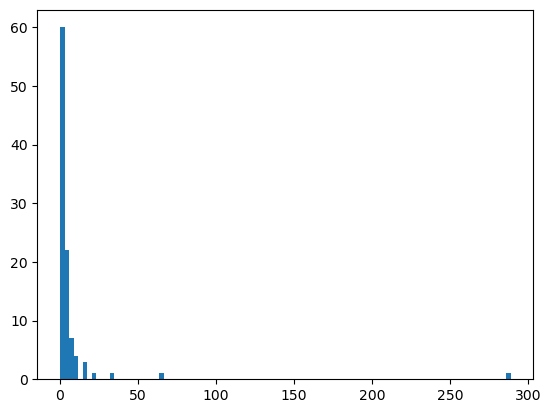

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\33771\AppData\Local\Temp\ipykernel_17916\1888353187.py:39: RuntimeWarning: overflow encountered in exp
  rapport_1 = np.exp(- np.log(p) - ln_proba_poisson +
C:\Users\33771\AppData\Local\Temp\ipykernel_17916\1888353187.py:110: RuntimeWarning: overflow encountered in exp
  rap_1 = np.exp(- np.log(p) - log_proba_poi +
100%|██████████| 1000/1000 [00:23<00:00, 42.04it/s]


param regress guess [0.92508548 2.1813616  3.61595898 5.7572174  6.6526088 ] p_guess 0.04288875962908486
nombre de refus [710. 114. 170. 162. 165.] nombre attemps 1001


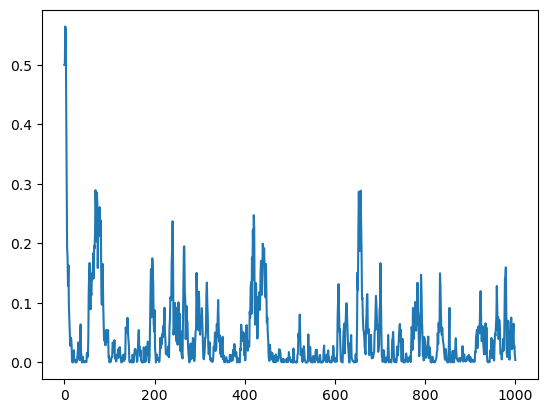

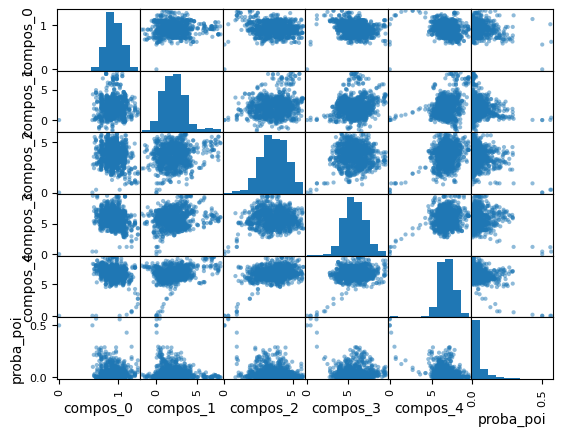

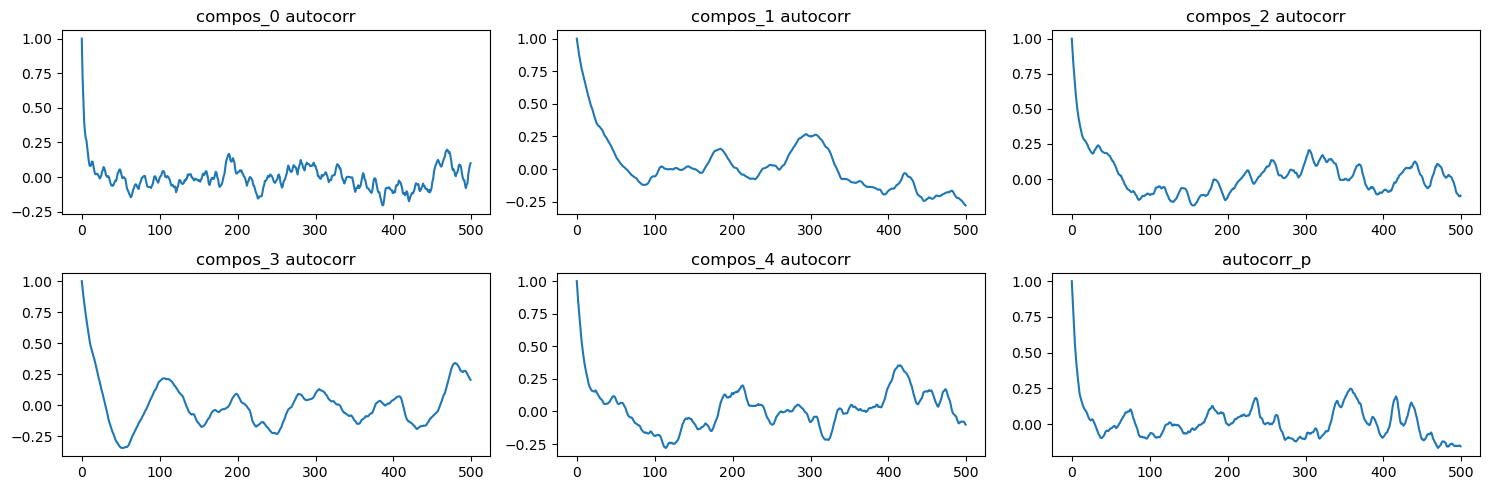

(array([0.92508548, 2.1813616 , 3.61595898, 5.7572174 , 6.6526088 ]),
 0.04288875962908486)

In [13]:
show_MH(mat,ly,n_MH,n_burn)

vérifier la cohérence de l'échantillon (autocorrélation etc...)

### Par Hamiltonien Monte-Carlo:

#### Auxiliaires et calculs

#### Fonction générale 

In [ ]:
#hamilt_sepa_gp(n_MH, mat, ly, np.zeros_like(vecteur_beta), 0.5)

def hamilt_sepa_gp(n_ite_apres_offset,X, ly, q_init, proba_init,eps = 0.01,L = 100, offset = 0,check = False):
    n = len(ly)  # nb données
    k = len(X[0, :])  # taille du beta
    # liste des variables positionnelles de la forme [beta sigma] dans une même liste
    li_q = [np.array(q_init)]
    li_p = [np.random.multivariate_normal(np.zeros(k), np.eye(k))]
    li_proba = [proba_init]
    G_prior_density = G_prior(X)
    refus = 0
    li_z = []
    li_log_fact = []
    for i in range(n):
        if ly[i] > 30:  # alors l'approximation de stirling devient bonne
            log_fact = ly[i]*np.log(ly[i])-ly[i] + 0.5 * \
                np.log(ly[i]) + np.log(np.sqrt(2*np.pi))  # stirling
        else:  # le calcul direct est faisable car la valeur est petite
            log_fact = np.log(float(scipy.special.factorial(ly[i])))
        li_log_fact.append(log_fact)
    li_fact = []
    for i in range(n):
        if ly[i] < 20:
            fact = float(scipy.special.factorial(ly[i]))
        else:
            fact = (ly[i]/np.exp(1))**ly[i]*np.sqrt(2*ly[i]*np.pi)
        li_fact.append(fact)

    # par est le vecteur des coefficients pour les deux régressions
    def log_proba_goal(par, proba_f):
        ln_proba = 0
        for i in range(n):
            # calcul de l'espérance pour les i-èmes variables explicatives de la régression poisson
            esp = np.exp(np.dot(X[i], par))
            # calcul de la probabilité p de réussite pour poisson (esp_géo peut valoir de 0 à +inf), cf convention choisie pour la loi géo
            # log de la probabilité p du succès dans la régression géométrique
            ln_p_geom = -np.log(esp + 1)
            # log de la probabilité q de l'échec dans la régression géométrique
            ln_q_geom = np.log(esp) - np.log(esp + 1)
            # calcul de la vraisemblance de la donnée y_i pour le modèle poisson
            ln_proba_poisson = -esp - li_log_fact[i] + ly[i]*np.log(esp)
            # calcul de la vraisemblance de la donnée y_i pour le modèle géométrique
            ln_proba_geo = ln_p_geom + ly[i]*ln_q_geom
            rapport_1 = np.exp(- np.log(proba_f) - ln_proba_poisson +
                               np.log(1-proba_f) + ln_proba_geo)  # rapport b/a où a = p*\pi(y|poisson,\theta) et b = (1-p)*\pi(y|géométrique,\theta)
            rapport_2 = np.exp(np.log(proba_f) + ln_proba_poisson -
                               np.log(1-proba_f) - ln_proba_geo)  # avec les mêmes conventions: rapport a/b
            # il est impossible que rapport_1 et rapport_2 soient ensemble écrasés à +inf. Et celui qui est écrasé à 0 donnera un résultat global correct (cf D.L de ln(1+x); x<<1)
            supplement_1 = np.log(
                proba_f) + ln_proba_poisson + np.log(1 + rapport_1)  # avec les notations précédentes: calcul de ln(a + b) = ln(a) + ln(1 + b/a)
            supplement_2 = np.log(1-proba_f) + ln_proba_geo + \
                np.log(
                    1 + rapport_2)  # avec les notations précédentes: calcul de ln(a + b) = ln(b) + ln(1 + a/b)
            if rapport_1 <= 1:  # i.e. si rapport_1 pas écrasé à l'infini
                supplement = supplement_1
            else:  # alors forcément rapport_2 pas écrasé à l'infini
                supplement = supplement_2
                if supplement_2 > 0:
                    print('aïe')
                    print([ln_proba_poisson, ln_proba_geo,
                           supplement, esp, ly[i], log_fact])
            ln_proba = ln_proba + supplement
        # probabilité des données sachant la théorie
        # on trouve log(proba(\beta,\sigma|p,X))
        ln_proba = ln_proba + G_prior_density.forward(par)
        return ln_proba

    # renvoit le gradient de E au point q = [beta_f sigma_f]

    '''
    def calcul_dE(beta_f, proba_f):
        # futur vecteur gradient (vecteur des dérivées partielles)
        dE = np.zeros(k)
        # cas où on prend la dérivée selon un beta[r] (r<k) et non selon sigma = q[k]
        for r in range(k):
            e_r = np.zeros(k)
            e_r[r] = 1  # vecteur qui vaut zéro partout sauf en r où il vaut 1
            dE[r] = (1/(2*n))*np.dot(X @ beta_f, X @ e_r)
            for i in range(n):
                lamb = np.exp(np.dot(X[i, :], beta_f))
                numerateur = X[i, r]*(lamb - ly[i])*(proba_f*np.exp(-lamb) /
                                                     li_fact[i] + (1-proba_f)/(1+lamb)**(2 + ly[i]))
                denominateur = proba_f * \
                    np.exp(-lamb)/li_fact[i] + \
                    (1 - proba_f)/(1 + lamb)**(1+ly[i])
                dE[r] = dE[r] + numerateur/denominateur
        return dE
    '''
    
    def calcul_dE(beta_f, proba_f):
        # futur vecteur gradient (vecteur des dérivées partielles)
        dE = np.zeros(k)
        # cas où on prend la dérivée selon un beta[r] (r<k) et non selon sigma = q[k]
        for r in range(k):
            e_r = np.zeros(k)
            e_r[r] = 1  # vecteur qui vaut zéro partout sauf en r où il vaut 1  
            dE[r] = (1/(2*n))*np.dot(X @ beta_f, X @ e_r)
            for i in range(n):
                lamb = np.exp(np.dot(X[i, :], beta_f))
                numerateur = proba_f*X[i,r]*(ly[i] - lamb)*lamb**ly[i]*np.exp(-lamb)/li_fact[i] + (1-proba_f)*X[i,r]*(ly[i]*(1 + 1/lamb)**(ly[i] - 1)*(1/lamb)*(1 + lamb) - lamb* (1 + 1/lamb)**ly[i])/((1 + lamb)**2*(1 + 1/lamb)**(2*ly[i]))
                denominateur = proba_f*lamb**(ly[i]) *np.exp(-lamb)/li_fact[i] + (1 - proba_f)/((1 + lamb)*(1 + 1/lamb)**ly[i])
                dE[r] = dE[r] - numerateur/denominateur
        return dE
    

    def calcul_H(q_f, p_f, proba_f):  # renvoit le hamiltonien en (q_f,p_f)
        E = - log_proba_goal(q_f, proba_f)  # énergie potentielle
        K = sum([0.5*p_f[i]**2 for i in range(k)])  # énergie cinétique
        return E + K  # hamiltonien

    # réalise une étape d'updating en partant de (q_dep,p_dep) (il y en a L dans une "grande étape")
    def step(q_dep, p_dep, proba_f, eps_step):
        # cf papier: dynamique hamiltonienne
        p_1 = np.copy(p_dep - (eps_step/2) *
                      calcul_dE(q_dep, proba_f))
        q_1 = np.copy(q_dep + eps_step*p_1)  # cf papier
        p_2 = np.copy(p_1 - (eps_step/2) *
                      calcul_dE(q_1, proba_f))  # cf papier
        return [q_1, p_2]

    n_ite = n_ite_apres_offset + offset
    for ite in tqdm(range(n_ite-1)):  # on va itérer n_ite fois une succession de L (petites) steps dans un sens ou l'autre avec acceptation ou non selon un processus MH
        q_dep = np.copy(li_q[len(li_q) - 1])  # on part d'ici
        q_previous = np.copy(li_q[len(li_q) - 1])  # sauvegarde là d'où on part
        #p_dep = np.copy(li_p[len(li_p) - 1])  # on part d'ici
        #p_previous = np.copy(li_p[len(li_p) - 1])  # sauvegarde d'où on part
        p_previous = np.random.multivariate_normal(np.zeros(k), np.eye(k))
        p_dep = np.copy(p_previous)
        nu = rd.random()  # Choix du sens dans lequel on ira pour la prochaine grande itération
        proba = li_proba[ite]
        if nu > 0.5:
            sens = 1  # direct
        else:
            sens = -1  # à reculon dans le temps
        for _ in range(L):
            # on fait une petite étape dans le sens qui convient (donné par sens*eps)
            q_pass, p_pass = np.copy(step(q_dep, p_dep, proba, sens*eps))
            q_dep = np.copy(q_pass)  # sauvegarder le résultat
            p_dep = np.copy(p_pass)  # idem
        # calculer le nouveau hamiltonien
        H_new = calcul_H(q_dep, p_dep, proba)
        if check is True:
            E_new = - log_proba_goal(q_dep, proba)
            E_previous = - log_proba_goal(q_previous, proba)
            delta_E = (E_new - E_previous)/np.linalg.norm(q_dep - q_previous)
            diff_E = np.dot(calcul_dE(q_previous, proba),q_dep  - q_previous )/np.linalg.norm(q_dep - q_previous)
            print('estimated:',delta_E,'calculated:', diff_E)
        # calculer l'ancien hamiltonien
        H_previous = calcul_H(q_previous, p_previous, proba)
        # calculer le facteur MH (cf papier)
        facteur = min(1, np.exp(H_previous - H_new))
        mu = rd.random()  # variable uniforme dans[0,1[
        if mu < facteur:  # alors on accepte
            q_pris = np.copy(q_dep)
            p_pris = np.copy(p_dep)
        else:  # alors on refuse
            q_pris = np.copy(q_previous)
            p_pris = np.copy(p_previous)
            #print('non')
            if ite > offset:
                refus = refus + 1
          # stocker la nouvelle valeur
        li_q.append(q_pris)
        # explorer une région avec un nouveau H (Gibbs Sampling)
        #li_p.append(np.random.multivariate_normal(np.zeros(k), np.eye(k))) #FAUX!
        li_p.append(p_pris)
        elem_z = []
        new_param = np.copy(q_pris)
        for i in range(n):  # etape de Gibbs sampling pour z
            test = np.log(rd.random())  # log d'une v.a. uniforme entre 0 et 1
            # valeur de l'espérance pour cette valeur de variables explicatives
            mu = np.exp(np.dot(X[i], new_param))
            # calculer le paramètre p de la régression géométrique pour cette valeur de variables explicatives
            ln_p_geo = -np.log(mu + 1)
            ln_q_geo = np.log(mu) - np.log(mu + 1)
            log_proba_poi = -mu - li_log_fact[i] + \
                ly[i]*np.log(mu)  # likelyhood modèle poisson
            log_proba_geo = ln_p_geo + ly[i]*ln_q_geo  # likelyhood modèle geo
            rap_1 = np.exp(- np.log(proba) - log_proba_poi +
                           np.log(1-proba) + log_proba_geo)
            rap_2 = np.exp(np.log(proba) + log_proba_poi -
                           np.log(1-proba) - log_proba_geo)
            # avec les notations précédentes: calcul de ln(a + b) = ln(a) + ln(1 + b/a)
            sum_1 = np.log(proba) + log_proba_poi + np.log(1 + rap_1)
            sum_2 = np.log(1-proba) + log_proba_geo + np.log(1 + rap_2)
            if sum_1 <= 0:
                sumgood = sum_1
            else:
                sumgood = sum_2
                if sumgood > 0:
                    print('erreur calcul sumgood')
            value = np.log(proba) + log_proba_poi - sumgood
            if test < value:
                elem_z.append(0)
            else:
                elem_z.append(1)
        li_z.append(elem_z)
        # nombre de y_i attribués à la seconde régression (géométrique)
        n_1 = sum(elem_z)
        # nombre de y_i attribués à la première régression (poisson)
        n_0 = n-n_1
        # distribution conjuguée: générer selon \pi(p|z_t,\theta_{t-1})
        new_proba = np.random.beta(0.5 + n_0, 0.5 + n_1)
        li_proba.append(new_proba)  # enregistrer la nouvelle valeur de p
    return [li_q[offset:], li_proba[offset:],li_z ,refus]

Tester le code

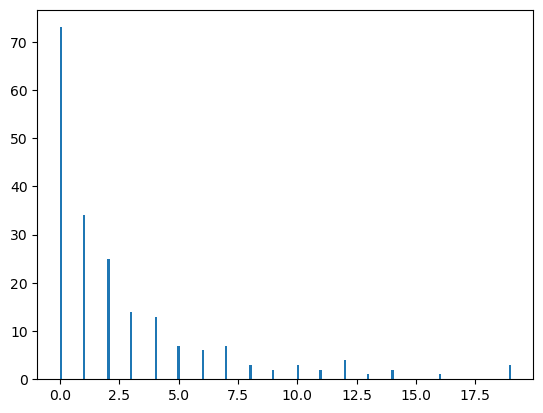

100%|██████████| 1499/1499 [02:55<00:00,  8.54it/s]


param regress guess [0.84456383 1.22463674 2.93191879 4.11503996 5.01146173] p_guess 0.04904541389209282
nombre de refus 9 nombre attemps 500


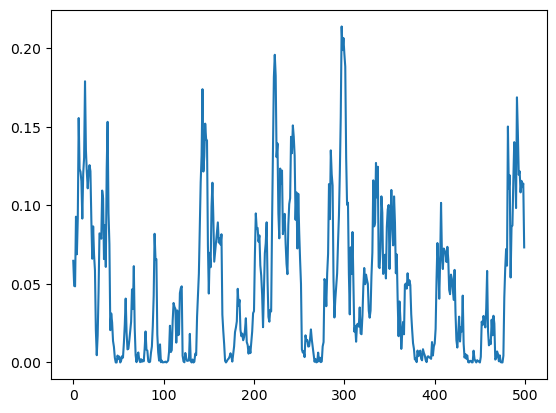

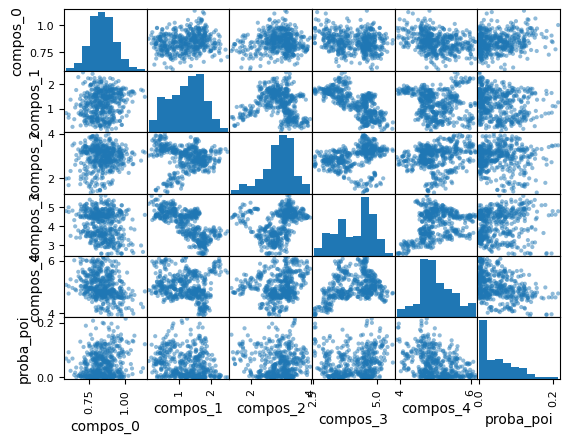

In [ ]:
vecteur_beta = np.array([1, 2, 3, 4, 5])
proba = 0
echant_size = 200
n_MH = 500
n_burn = 0
offset = 1000
L = 10
eps = 0.01
#
mat, ly = mel_poi_geo(np.array(vecteur_beta), proba, echant_size)
plt.hist(np.array(ly), bins=echant_size)
plt.show()
li_param, li_p, li_z, refus_param, = hamilt_sepa_gp(n_MH, mat, ly, np.zeros_like(vecteur_beta),0.5,eps = eps,L = L,offset = offset,check = False)  # chercher à séparer les paramètres
# éliminer les n_burn premières valeurs et prendre l'espérance de p
p_guess = sum(li_p[n_burn:])/(n_MH - n_burn)
param_guess = np.zeros_like(vecteur_beta,dtype = float)
for i in range(n_MH - n_burn):  #dégager n_burn
    for j in range(len(vecteur_beta)):
        param_guess[j] = param_guess[j] + li_param[i+n_burn][j]
param_guess = np.array(param_guess)/(n_MH - n_burn)
# afficher les paramètres "devinés"
print('param regress guess',param_guess,'p_guess', p_guess)
print('nombre de refus',refus_param, 'nombre attemps', len(li_param))
li_p = np.array(li_p)
plt.plot(li_p)
plt.show()
new_li_pasarray = []
for i in range(len(li_param) - n_burn):
    elem = []
    for j in range(len(li_param[0])):
        elem.append(li_param[i + n_burn][j])
    elem.append(li_p[i + n_burn])
    new_li_pasarray.append(elem)
matrix_totale = np.array(new_li_pasarray)
df = pd.DataFrame(matrix_totale, columns=[
                  'compos_0', 'compos_1', 'compos_2', 'compos_3', 'compos_4', 'proba_poi'])
pd.plotting.scatter_matrix(df)
plt.show()

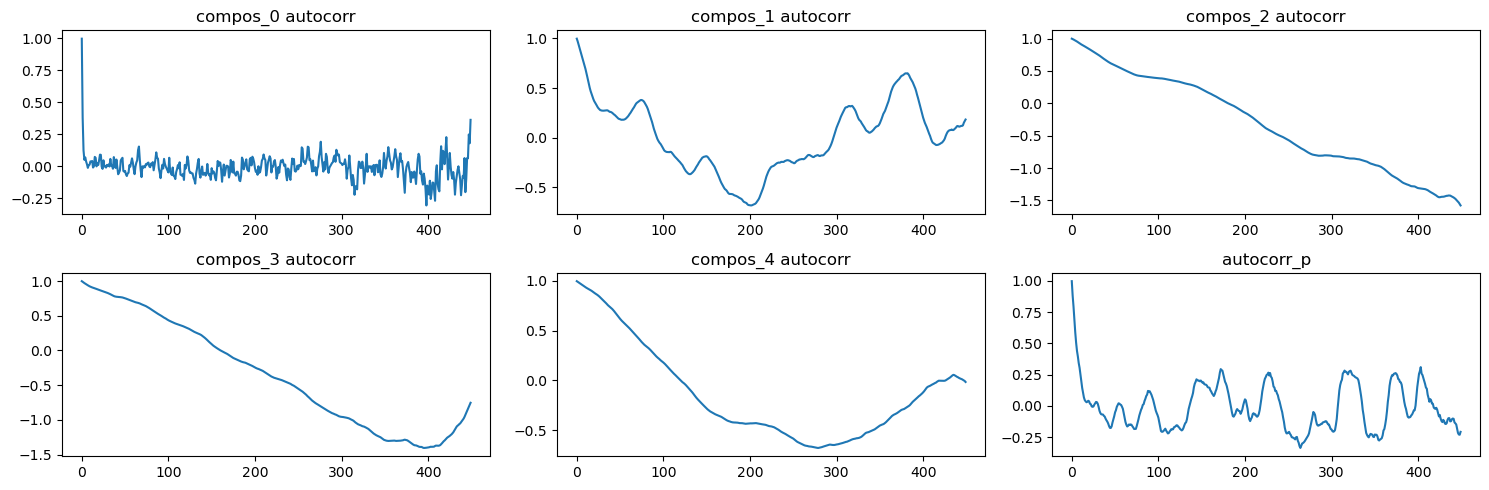

In [ ]:
vue_auto_corr = min(int(0.9*(n_MH - n_burn)),500)
n_compos = len(vecteur_beta)
n_rows = n_compos//3 +1

fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5))  # 3 graphiques par ligne
#for i, ax in enumerate(axes.flat):
for i in range(n_compos + 1):
    ax = axes.flat[i]
    ax.plot([autocor(matrix_totale[:,i],j) for j in range(vue_auto_corr)])
    if i < n_compos:
        ax.set_title(f'compos_{i} autocorr')
    else:
        ax.set_title('autocorr_p')

plt.tight_layout()
plt.show()

### Importer les données réelles

In [38]:
# Charger les données CSV dans un DataFrame Pandas avec les noms de colonnes
std_scaler = StandardScaler()
df = pd.read_csv('mdvis.csv')
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.25)
# Afficher les premières lignes du DataFrame
def get_data(df):
    y = df.loc[:,['numvisit']].values
    y = y.reshape(-1)
    x = df.loc[:,['reform','badh','age','educ','educ1','educ2','educ3','agegrp','age1','age2','age3','loginc']].values
    x = std_scaler.fit_transform(x)
    ones = np.ones((x.shape[0], 1), dtype = float)
    x = np.hstack((ones,x))
    return x,y

x_tot,y_tot = get_data(df)
x_train,y_train = get_data(df_train)
x_test,y_test = get_data(df_test)

def cut_train(x_train,y_train,echant_size):
    n = len(y_train)
    indices = np.random.choice(n,echant_size,replace = False)
    x_train = x_train[indices]
    y_train = y_train[indices]
    return x_train,y_train, indices

x_cut_train,y_cut_train, indices = cut_train(x_train,y_train,200)
print(x_cut_train.shape,y_cut_train.shape)
print(x_tot.shape,y_tot.shape)

(200, 13) (200,)
(2227, 13) (2227,)


Correlations surtout l'échantillon

In [39]:
def cov_mat(x):
    df_covariables = pd.DataFrame(x)  # Remplacez x_tot par votre matrice de covariables
    # Calculer la matrice de corrélation
    corr_matrix = df_covariables.corr()
    # Afficher la matrice de corrélation avec seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

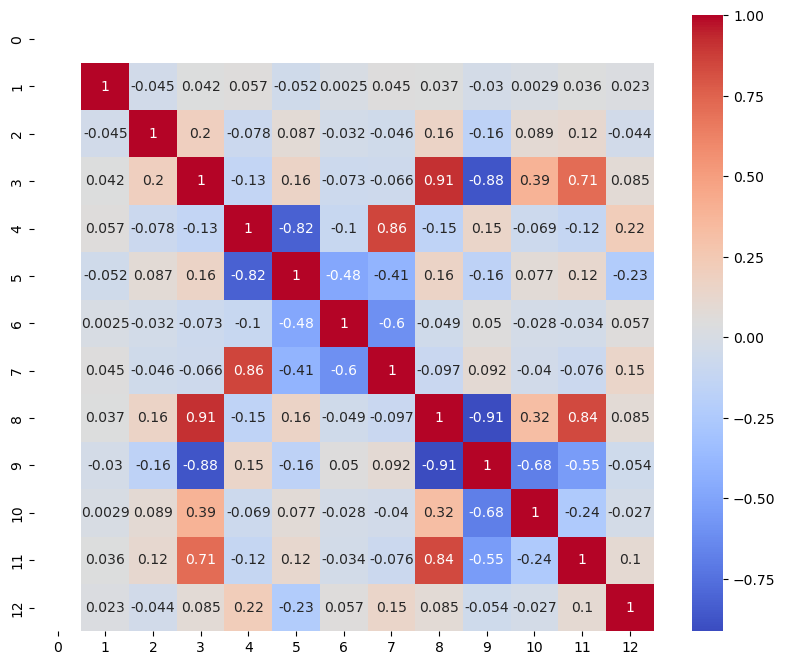

In [14]:
cov_mat(x_tot)

Corrélations random par comparaison

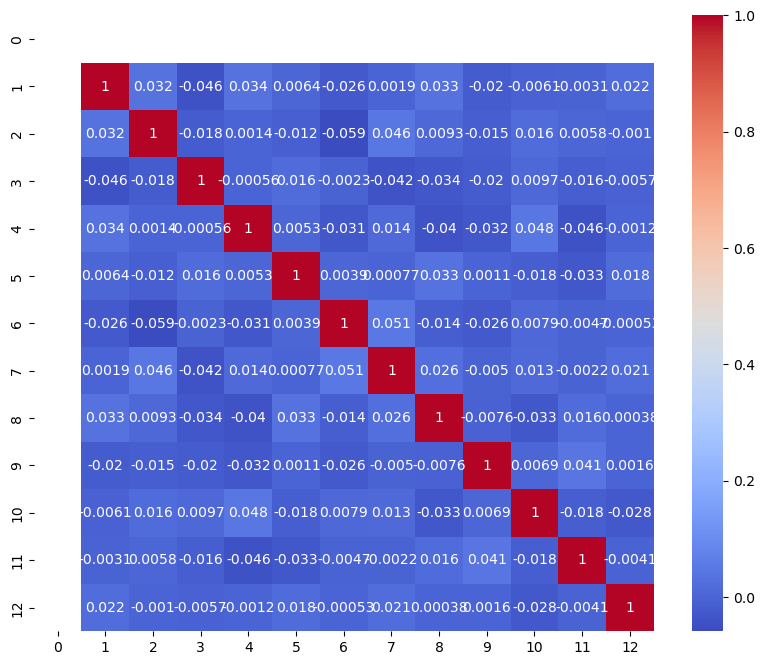

In [44]:
proba = 0
echant_size = 2227
vecteur_beta = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13])
mat, ly = mel_poi_geo(np.array(vecteur_beta), proba, echant_size)
cov_mat(mat)

PCA

In [40]:
pca = PCA(n_components=8)
pca.fit(x_tot[:,1:])
#x_tot_pca = pca.transform(x_tot[:,1:])
x_tot_pca = np.hstack((x_tot[:,0].reshape(-1,1),pca.transform(x_tot[:,1:]) ))
print('ratio of sigma explained',pca.explained_variance_ratio_)


ratio of sigma explained [0.31374149 0.19926777 0.13259859 0.11093036 0.08508917 0.07813053
 0.07061555 0.00962654]


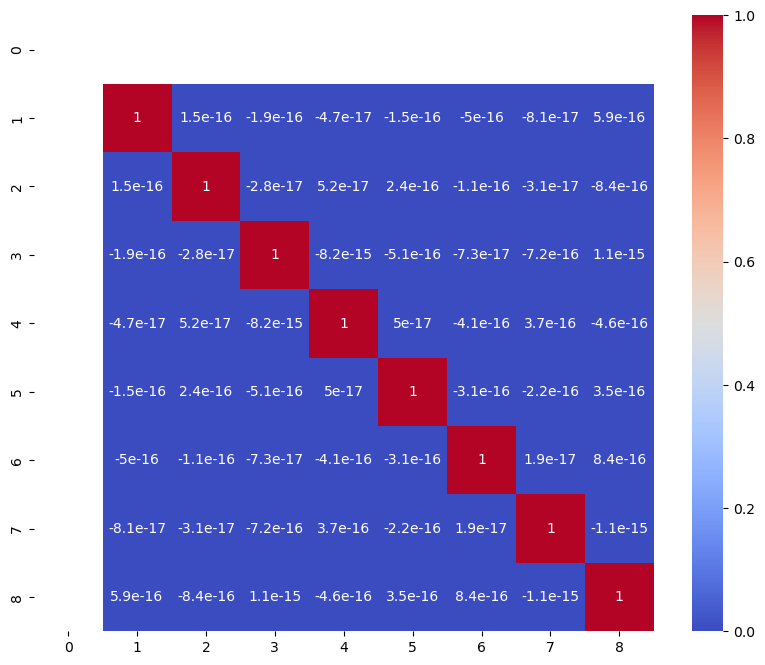

In [16]:
cov_mat(x_tot_pca)

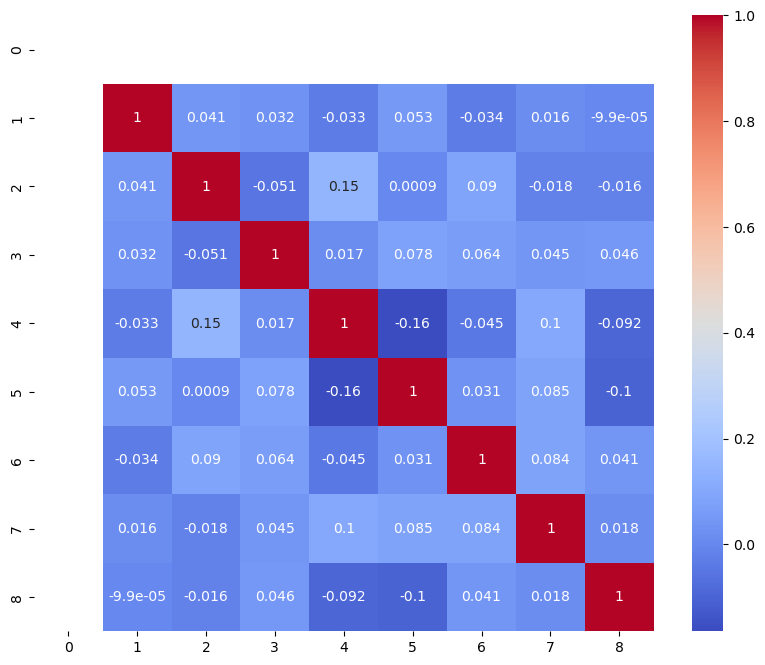

In [41]:
x_cut_train_pca =   np.hstack((x_cut_train[:,0].reshape(-1,1),pca.transform(x_cut_train[:,1:]) ))
cov_mat(x_cut_train_pca)
x_test_pca =  np.hstack((x_test[:,0].reshape(-1,1),pca.transform(x_test[:,1:]) ))
x_train_pca = np.hstack((x_train[:,0].reshape(-1,1),pca.transform(x_train[:,1:]) ))


### Tester sur les données réelles avec MH classique

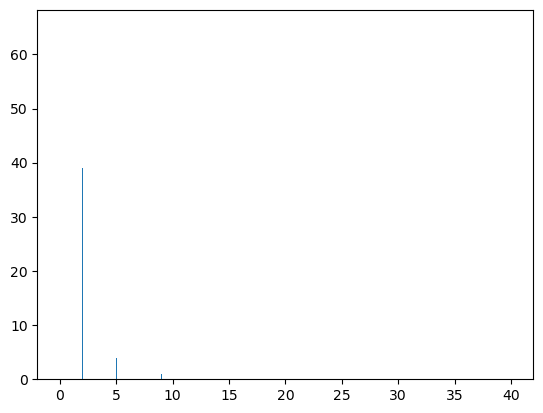

  2%|▏         | 88/5000 [00:05<05:15, 15.58it/s]C:\Users\33771\AppData\Local\Temp\ipykernel_20984\1888353187.py:39: RuntimeWarning: overflow encountered in exp
  rapport_1 = np.exp(- np.log(p) - ln_proba_poisson +
100%|██████████| 5000/5000 [05:34<00:00, 14.93it/s]


param regress guess [ 0.13153266  0.09067742  0.04736925 -0.02412193  0.44936571  0.21159276
 -0.00881954] p_guess 0.05823228437848142
nombre de refus [4478. 4351. 4158. 4173. 4149. 3996. 3912.] nombre attemps 5001


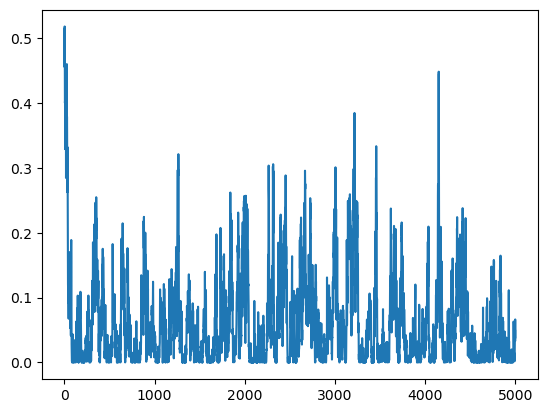

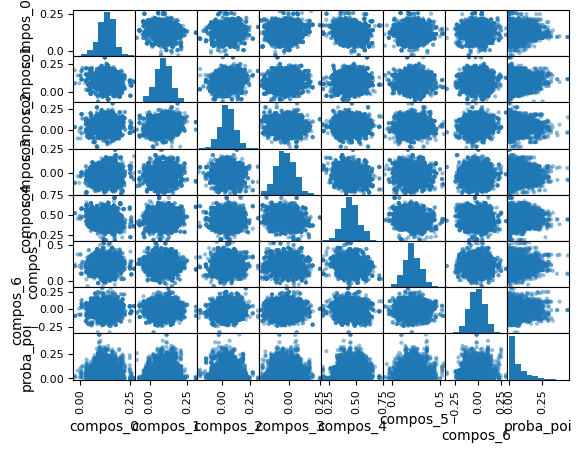

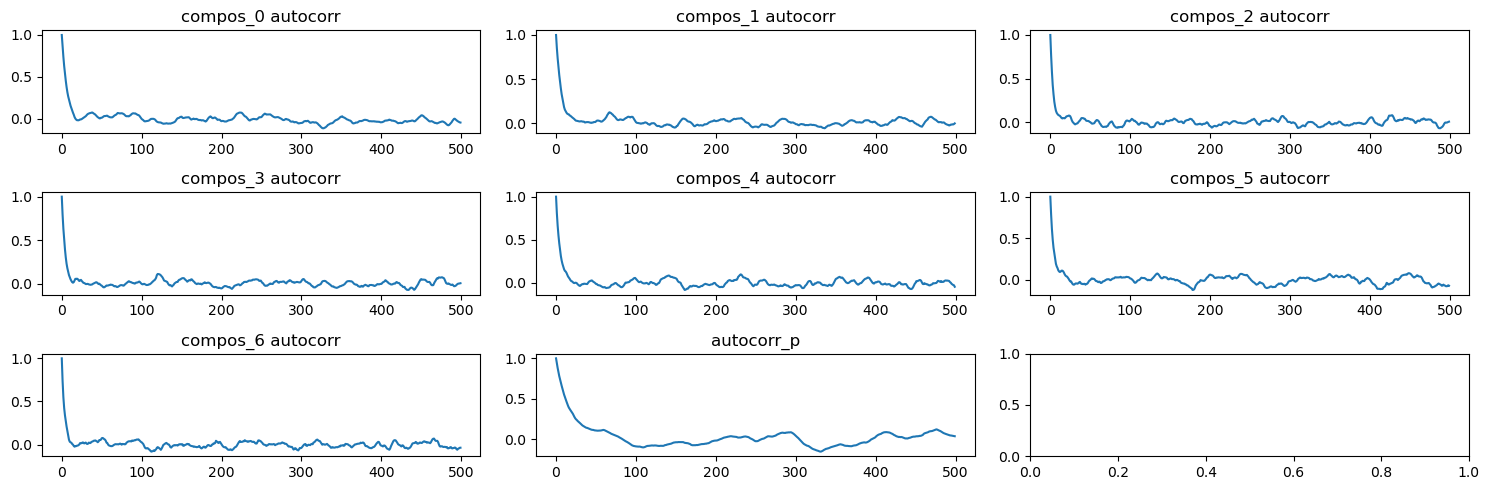

(array([ 0.13153266,  0.09067742,  0.04736925, -0.02412193,  0.44936571,
         0.21159276, -0.00881954]),
 0.05823228437848142)

In [49]:
n_MH = 5000
n_burn  = 1000
show_MH(x_cut_train_pca,y_cut_train,n_MH,n_burn)

Attempt Bayesian ppca: pas concluant pour l'instant

In [32]:
from ppca.ppca import PPCA
ppca = PPCA(D = 7)
ppca.fit(x_tot[:,1:])

0.04711186560264859
(2227, 13)
0.04711186560264859
0.870736513892307


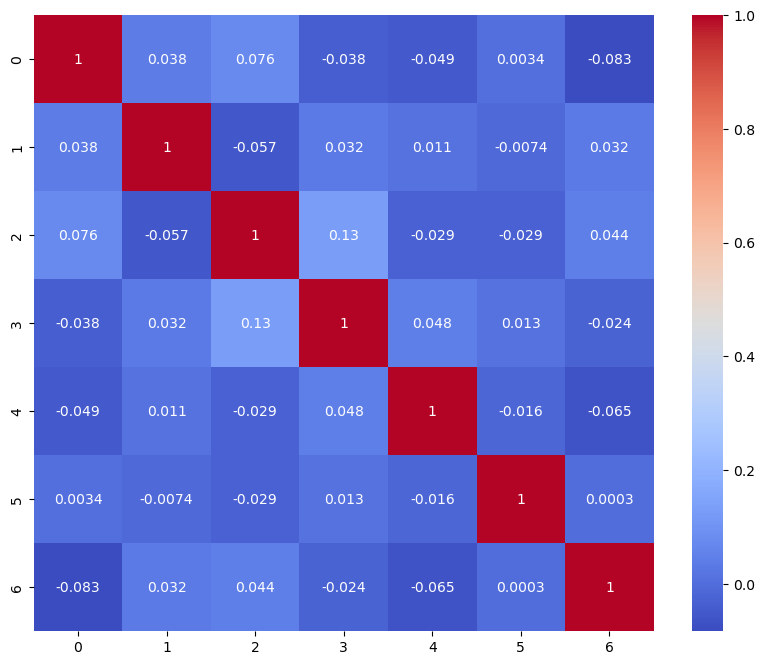

In [33]:
train_index = df_train.index
cut_index = train_index[indices]
result = ppca.recover()
recons = np.hstack((x_tot[:,0].reshape(-1,1),result))
e_X = ppca.e_X
e_w  = ppca.e_w
print(np.abs(recons - x_tot).mean())
print(np.hstack((x_tot[:,0].reshape(-1,1),np.abs(e_X.dot(e_w.T)))).shape)
print((np.abs(np.hstack((x_tot[:,0].reshape(-1,1),e_X.dot(e_w.T))) - x_tot)).mean())
print(np.abs(x_tot).mean())
cov_mat(e_X)

In [34]:
e_X = np.hstack((x_tot[:,0].reshape(-1,1),e_X)) 
e_X_train_cut = e_X[cut_index]
print(e_X_train_cut.shape)
print(x_cut_train.shape)
print((np.abs(np.hstack((x_cut_train[:,0].reshape(-1,1),e_X_train_cut[:,1:].dot(e_w.T))) - x_cut_train)).mean())

(200, 8)
(200, 13)
0.04373684780320577


Use the PPCA for Predictions

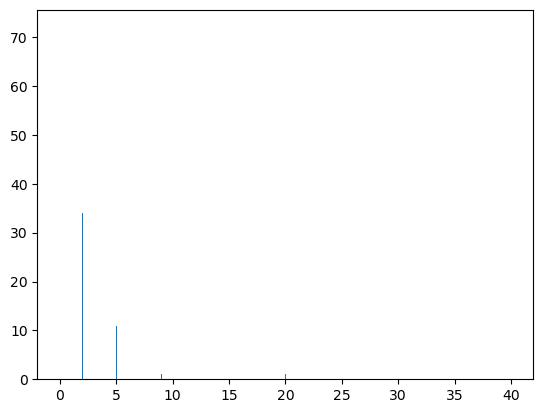

  3%|▎         | 132/5000 [00:11<06:33, 12.38it/s]C:\Users\33771\AppData\Local\Temp\ipykernel_20984\1888353187.py:39: RuntimeWarning: overflow encountered in exp
  rapport_1 = np.exp(- np.log(p) - ln_proba_poisson +
100%|██████████| 5000/5000 [06:48<00:00, 12.24it/s]


param regress guess [ 0.36245572  0.23139758  0.21730272 -0.31817368  0.45576052 -0.01959452
 -0.21821545 -0.04615974 -0.38259409] p_guess 0.04190463432845712
nombre de refus [4038. 3757. 3839. 3872. 3880. 3805. 3810. 3840. 3846.] nombre attemps 5001


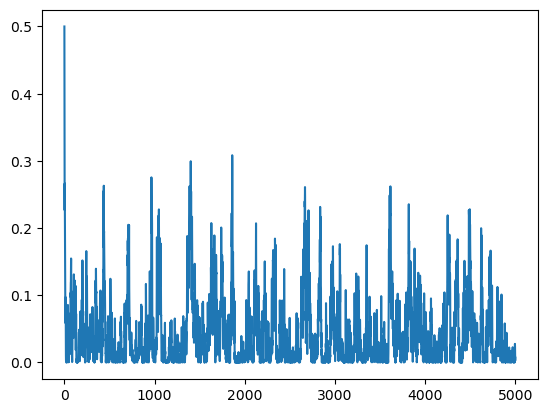

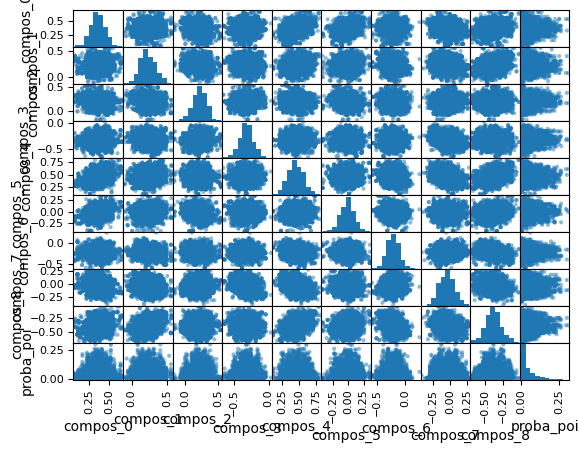

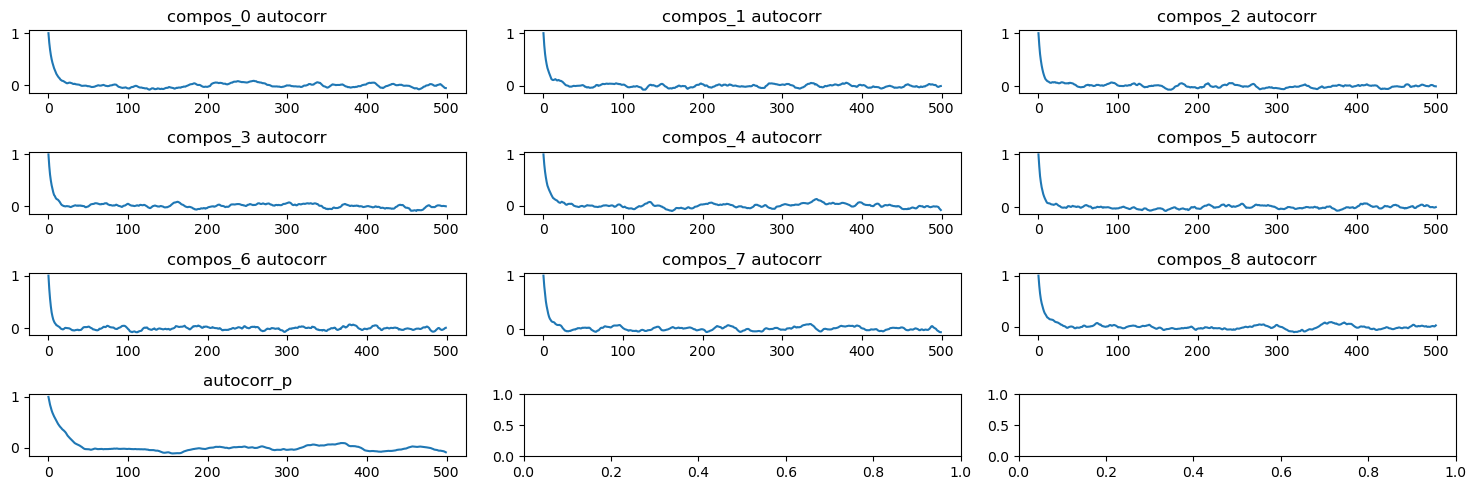

(array([ 0.36245572,  0.23139758,  0.21730272, -0.31817368,  0.45576052,
        -0.01959452, -0.21821545, -0.04615974, -0.38259409]),
 0.04190463432845712)

In [106]:
n_MH = 5000
n_burn  = 1000
show_MH(e_X_train_cut,y_cut_train,n_MH,n_burn)

VIF

In [35]:
vif_init = [variance_inflation_factor(x_tot, i) for i in range(x_tot.shape[1])]
print('initially',vif_init)
vif_PCA = [variance_inflation_factor(x_tot_pca, i) for i in range(x_tot_pca.shape[1])]
print('usual PCA',vif_PCA)
vif_ppca = [variance_inflation_factor(e_X, i) for i in range(e_X.shape[1])]
print('probabilistic PCA',vif_ppca)

initially [1.0, 1.0087324792112466, 1.0511326703132506, 6.526149811978359, inf, inf, inf, inf, inf, inf, inf, inf, 1.0829125838448015]
usual PCA [1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0]
probabilistic PCA [1.0, 1.0211575087725353, 1.0087659886426292, 1.0339694420886167, 1.0256450438988045, 1.0104239263114163, 1.0015429467570016, 1.0168703126883587]


c:\Users\33771\.conda\envs\transform\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Régression géométrique classique

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class network(nn.Module):
    def __init__(self,k):
        super(network,self).__init__()
        self.k = k
        self.param = nn.Parameter(torch.randn(k,1))

    def forward(self,x):

        x = torch.sum(x * self.param.view(1,-1),dim = 1)
        return x

In [45]:
class reg_geo:
    def __init__(self,X,y,X_test,y_test,network,lr = 0.01, n_iter = 1000):
        self.lr = lr
        self.X = torch.from_numpy(X).float().to(device)
        self.y = torch.from_numpy(y).int().to(device)
        self.X_test = torch.from_numpy(X_test).float().to(device)
        self.y_test = torch.from_numpy(y_test).int().to(device)
        self.network = network
        self.k = X.shape[1]
        self.n_iter =n_iter

        
    def log_lik(self,X,y, cor = 10**(-10)):
        esp = torch.exp(self.network(X))
        #print(esp)
        ln_p_geom = -torch.log(esp + 1)
        # log de la probabilité q de l'échec dans la régression géométrique
        #print(cor)
        ln_q_geom = torch.log(esp) - torch.log(esp + 1)
        #print(ln_p_geom.shape)
        log_probas = ln_p_geom + y*ln_q_geom
        #print(log_probas)
        return - torch.sum(log_probas)
    
    def fit(self):
        optimizer = torch.optim.Adam(self.network.parameters(), lr = self.lr, weight_decay=0.00001)
        for i in range(self.n_iter):
            optimizer.zero_grad()
            loss = self.log_lik(self.X,self.y)
            loss.backward()
            if i%100 == 0:
                moy_grad = torch.mean(torch.abs(self.network.param.grad))
            optimizer.step()
            if i % 100 == 0:
                print('loss',loss.item(),'grad_moys',moy_grad.item())
            #tester le modèle sur les données de test: calculer sa mse
            if i % 100 == 0:
                y_pred = self.network(self.X_test)
                mse = torch.mean((y_pred - self.y_test)**2).item()
                print('mse',mse,'pourcentage de bonnes prédictions',(torch.sum((y_pred > 0.5) == self.y_test).float()/len(self.y_test)).item())



In [46]:
net = network(k = x_cut_train_pca.shape[1]).to(device)
regression = reg_geo(x_train_pca,y_train,x_test_pca,y_test,net,lr = 0.0001, n_iter = 40000)
regression.fit()
beta = net.param.detach().cpu().numpy()
print(beta)

loss 8042.09765625 grad_moys 1297.44482421875
mse 18.05817222595215 pourcentage de bonnes prédictions 0.28007182478904724
loss 7926.3212890625 grad_moys 1280.85791015625
mse 17.880144119262695 pourcentage de bonnes prédictions 0.28007182478904724
loss 7812.6689453125 grad_moys 1264.5750732421875
mse 17.70490264892578 pourcentage de bonnes prédictions 0.2782764732837677
loss 7701.00927734375 grad_moys 1248.86376953125
mse 17.5321102142334 pourcentage de bonnes prédictions 0.2782764732837677
loss 7591.16015625 grad_moys 1234.9742431640625
mse 17.361469268798828 pourcentage de bonnes prédictions 0.2782764732837677
loss 7482.9794921875 grad_moys 1222.7314453125
mse 17.19289779663086 pourcentage de bonnes prédictions 0.28007182478904724
loss 7376.3818359375 grad_moys 1210.118896484375
mse 17.026519775390625 pourcentage de bonnes prédictions 0.28007182478904724
loss 7271.34765625 grad_moys 1197.1578369140625
mse 16.86253547668457 pourcentage de bonnes prédictions 0.28007182478904724
loss 716

In [48]:
regression = reg_geo(x_train_pca,y_train,x_test_pca,y_test,net,lr = 0.0001, n_iter = 100)
regression.fit()
beta = net.param.detach().cpu().numpy()
print(beta)

loss 3478.03369140625 grad_moys 0.00015873379015829414
mse 9.153406143188477 pourcentage de bonnes prédictions 0.21903052926063538
[[ 0.89164805]
 [ 0.08214159]
 [-0.00165658]
 [ 0.03457969]
 [ 0.00174509]
 [ 0.2888568 ]
 [ 0.20806073]
 [ 0.15271913]
 [-0.0607131 ]]
